### What's the result in *March Madness*(2019-2020) if coronavirus did not spread?
### Do players fail to match, match, or exceed expectations according to their previous seasons?

Basically, these are two opening questions related to various factors:
* Players' physical condition at the time
* Audiences' support for the host team
* Psychological quality for coaches and players
* Weather, competitiveness, and chance

In this notebook, first, we will try to **make a prediction of the tournament result in season 2019-2020**. Second, we will seek to quantify the player influence as objective as possible, by abusing the terminology of the official definition, **define how influential college basketball player can be**.

Trying to use the existing official definition to metric players' influence, such as Impact defined in this [article](https://www.kaggle.com/lucabasa/quantify-the-madness-a-study-of-competitiveness#Conclusions,-limits,-and-next-steps) and WS(Win Share) may be too subjective, although the existing official definition has its own reasonability. However, the core merit of this notebook is using an objective metric to measure players' influence. We use the information of every player as our input, team competition results as our target(only two values--0 and 1), and then build Logistic Regression. Then we use the results of Logistic Regression to inversely predict the information of every player. Last, we compare the distribution between Impact with the results of our method and we find they are both seem reasonable.

While some [differences between the two tournaments](https://www.kaggle.com/lucabasa/are-men-s-and-women-s-tournaments-different) can be found, we find that our method can be used in both situations. We will compare  players' influence between the result that we predict and the official definition.

This notebook is organized as follows
* Data Preparation:  the key concept will be summarized in this section and the main output will be displayed.
* Model Selection and Prediction: the prediction of competition results in season 2019-2020 and model will be showed.
* Player Influence: where a Machine Learning model will guide us towards the definition of our players' influence.
* Team Influence: where shows the average performance of players' influence
* Limits and next steps: where we will conclude our story.

# Data Preparation

In this part, we start to clean the data for our usage. Our ultimate goal is to estimate the team impacts and how this could lead to game results, the data we use came from the Regular Season statistics and tourney competitions from 2015 to 2019. Towards this goal, we managed to quantify the performance of various teams in every single season simply by averaging the games stats, including points, assists, rebounds, blocks, etc., that they played. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns
plt.style.use('seaborn-dark-palette')
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal
import os
import gc

In [ ]:
def mkdir(path):
    import os
    path = path.strip()
    path = path.rstrip("\\")
    isExists = os.path.exists(path)
    if not isExists:
        os.makedirs(path)
        print(path + 'Successufully established')
        return True
    else:
        print(path + 'dir existed')
        return False

In [ ]:
MENS_DIR = '../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1'
WOMENS_DIR = '../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Womens-Data/WDataFiles_Stage1'
Mss = pd.read_csv(f'{MENS_DIR}/MTeams.csv')
Wss = pd.read_csv(f'{WOMENS_DIR}/WTeams.csv')

In [ ]:
M_drop_list = ["FirstD1Season","TeamName","LastD1Season"]
W_drop_list = ['TeamName']
Mss.drop(M_drop_list,axis = 1,inplace = True)
Wss.drop(W_drop_list,axis = 1,inplace = True)
# Team_box
time_list = [2015,2016,2017,2018,2019]

In [ ]:
Mss = pd.read_csv(f'{MENS_DIR}/MTeams.csv')
Wss = pd.read_csv(f'{WOMENS_DIR}/WTeams.csv')
M_Seed = pd.read_csv(f'{MENS_DIR}/MNCAATourneySeeds.csv')
W_Seed = pd.read_csv(f'{WOMENS_DIR}/WNCAATourneySeeds.csv')
M_Team_seed = M_Seed[M_Seed['Season'].isin(time_list)]
W_Team_seed = W_Seed[W_Seed['Season'].isin(time_list)]
M_game_result_detailed =  pd.read_csv(f'{MENS_DIR}/MRegularSeasonDetailedResults.csv')
W_game_result_detailed =  pd.read_csv(f'{WOMENS_DIR}/WRegularSeasonDetailedResults.csv')

In [ ]:
M_game_result_detailed = M_game_result_detailed[M_game_result_detailed['Season'].isin(time_list)]
W_game_result_detailed = W_game_result_detailed[W_game_result_detailed['Season'].isin(time_list)]

In [ ]:
win_list = ['Season','WTeamID','WScore','WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']
M_game_result_win = M_game_result_detailed[win_list]
W_game_result_win = W_game_result_detailed[win_list]
lose_list = ['Season','LTeamID','LScore','LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']
M_game_result_lose = M_game_result_detailed[lose_list]
W_game_result_lose = W_game_result_detailed[lose_list]

In [ ]:
M_team_win_box = M_game_result_win.groupby(['WTeamID','Season']).count()
W_team_win_box = W_game_result_win.groupby(['WTeamID','Season']).count()

In [ ]:
drop_list = ['WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']
M_team_win_box = M_team_win_box.drop(drop_list,axis = 1)
W_team_win_box = W_team_win_box.drop(drop_list,axis = 1)
M_team_win_box = M_team_win_box.rename(columns = {'WScore':'count'})
W_team_win_box = W_team_win_box.rename(columns = {'WScore':'count'})

In [ ]:
M_team_count = M_team_win_box.reset_index()
W_team_count = W_team_win_box.reset_index()

In [ ]:
M_team_win_box = M_game_result_win.groupby(['WTeamID','Season']).sum()
M_team_win_box = M_team_win_box.reset_index()
M_team_win_box = pd.merge(M_team_win_box,M_team_count,on = ['WTeamID','Season'])
win_rename_columns = {'WTeamID':"TeamID","WScore":"Score",'WFGM':'FGM', 'WFGA':'FGA', 'WFGM3':'FGM3', 'WFGA3':'FGA3',
       'WFTM':'FTM', 'WFTA':'FTA', 'WOR':'OR', 'WDR':'DR', 'WAst':'Ast', 'WTO':'TO', 'WStl':'Stl', 'WBlk':'Blk', 'WPF':'PF'}
M_team_win_box = M_team_win_box.rename(columns=win_rename_columns)
M_team_win_box.head()

In [ ]:
W_team_win_box = W_game_result_win.groupby(['WTeamID','Season']).sum()
W_team_win_box = W_team_win_box.reset_index()
W_team_win_box = pd.merge(W_team_win_box,W_team_count,on = ['WTeamID','Season'])
W_team_win_box = W_team_win_box.rename(columns=win_rename_columns)
W_team_win_box.head()

In [ ]:
M_team_lose_box = M_game_result_lose.groupby(['LTeamID','Season']).count()
drop_list = ['LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR',
       'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']
M_team_lose_box = M_team_lose_box.drop(drop_list,axis = 1)
M_team_lose_box = M_team_lose_box.rename(columns = {'LScore':'count'})

In [ ]:
W_team_lose_box = W_game_result_lose.groupby(['LTeamID','Season']).count()
W_team_lose_box = W_team_lose_box.drop(drop_list,axis = 1)
W_team_lose_box = W_team_lose_box.rename(columns = {'LScore':'count'})
M_team_lose_count = M_team_lose_box.reset_index()
W_team_lose_count = W_team_lose_box.reset_index()

In [ ]:
M_result_lose = M_game_result_lose.groupby(['LTeamID','Season']).sum()
M_team_lose_box = M_result_lose.reset_index()
M_team_lose_box = pd.merge(M_team_lose_box,M_team_lose_count,on = ['LTeamID','Season'])
rename_columns = {'LTeamID':"TeamID","LScore":"Score",'LFGM':'FGM', 'LFGA':'FGA', 'LFGM3':'FGM3', 'LFGA3':'FGA3',
       'LFTM':'FTM', 'LFTA':'FTA', 'LOR':'OR', 'LDR':'DR', 'LAst':'Ast', 'LTO':'TO', 'LStl':'Stl', 'LBlk':'Blk', 'LPF':'PF'}
M_team_lose_box = M_team_lose_box.rename(columns=rename_columns)
W_result_lose = W_game_result_lose.groupby(['LTeamID','Season']).sum()
W_team_lose_box = W_result_lose.reset_index()
W_team_lose_box = pd.merge(W_team_lose_box,W_team_lose_count,on = ['LTeamID','Season'])
W_team_lose_box = W_team_lose_box.rename(columns=rename_columns)

In [ ]:
M_result = pd.merge(M_team_win_box,M_team_lose_box,on=['TeamID','Season'])
W_result = pd.merge(W_team_win_box,W_team_lose_box,on=['TeamID','Season'])
M_result = M_team_win_box.append(M_team_lose_box)
W_result = W_team_win_box.append(W_team_lose_box)

In [ ]:
M_result = M_result.groupby(['TeamID','Season']).sum()
W_result = W_result.groupby(['TeamID','Season']).sum()

In [ ]:
element_list = ['Score','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','TO','Stl','Blk','PF','Ast']
M_result = M_result[element_list].apply(lambda x:x/M_result['count'])
W_result = W_result[element_list].apply(lambda x:x/W_result['count'])
M_result_withseed = pd.merge(M_result,M_Team_seed,on=['TeamID','Season'],how = 'outer')
W_result_withseed = pd.merge(W_result,W_Team_seed,on=['TeamID','Season'],how = 'outer')
M_team_win_box = M_result_withseed.rename(columns = {'TeamID':'WTeamID'})
M_team_lose_box = M_result_withseed.rename(columns = {'TeamID':'LTeamID'})
W_team_win_box = W_result_withseed.rename(columns = {'TeamID':'WTeamID'})
W_team_lose_box = W_result_withseed.rename(columns = {'TeamID':'LTeamID'})

In [ ]:
M_result_withseed.to_csv('M_result.csv')
W_result_withseed.to_csv('W_result.csv')

To load the data of regular season, use 'MRegularSeasibCompactResults.csv' or 'WRegularSeasibCompactResults.csv'

In [ ]:
M_game_result =  pd.read_csv(f'{MENS_DIR}/MNCAATourneyCompactResults.csv')
M_game_result = M_game_result[M_game_result['Season'].isin(time_list)]
W_game_result =  pd.read_csv(f'{WOMENS_DIR}/WNCAATourneyCompactResults.csv')
W_game_result = W_game_result[W_game_result['Season'].isin(time_list)]

In [ ]:
M_game_result_1 = pd.merge(M_game_result,M_team_win_box,on=['WTeamID','Season'],how = 'left')
W_game_result_1 = pd.merge(W_game_result,W_team_win_box,on=['WTeamID','Season'],how = 'left')
M_game_result_final = pd.merge(M_game_result_1,M_team_lose_box,on=['LTeamID','Season'],how = 'left')
W_game_result_final = pd.merge(W_game_result_1,W_team_lose_box,on=['LTeamID','Season'],how = 'left')

M_game_result_final.to_csv('M_result_by_game_tourney.csv')
W_game_result_final.to_csv('W_result_by_game_tourney.csv')

Our final result is as follows. This df contains two groups of information, which respectively come from two teams in the game. The columns with the subscript "x" are from the winning team, the columns with the subscript "y" are from another team. 

In [ ]:
M_game_result_final.head()

# Model Selection and Prediction

In our approach, we applied Logistic Regression, XGboost and pygam for prediction. Our goal is to estimate the winning rate of two teams in a game. Similiarly, the results of the different methods are around 0.7. When we got all the results of three models, ensembling learning is utilized to stack all the models and make a prediction for the final result. 

## Logistic Regression

In this section, the goal of our task is to predict the win percentage given two teams in NCAA. Denote the response as

 $$response(Team X,Team Y) =\left\{\begin{array}{ll}1, & \text { Team X won}  \\ 0, & \text { Team X lost}\end{array}\right.$$

Then, it is natural to come to the Logistic Regression, which models the probability that the game result belongs to a particular category .
  For the game result data, logistic regression method models the probability of game results. For example, the probability of game results given inputs (average score, FGM, FGA, FGM3, etc ) can be written as

$$Pr(game result = Win | inputs)=Pr(response=1| inputs)$$

The values of Pr(game result = Win | inputs) ranges from 0 to 1. Then for any given values of inputs, a prediction of game result can be made.


$$p(\textbf{X})=\frac{e^{\beta_{0}+\beta_{1} X_{1}+\ldots +\beta_{k} X_{k}}}{1+e^{\beta_{0}+\beta_{1} X_{1}+\ldots +\beta_{k} X_{k}}}$$

In logistic learning, we chose both teams' regular season basic detailed statistic data like average score, FGM, FGA, FGM3, FGA3, FTM, FTA, #offensive rebounds, #defensive rebounds, #assitants, #turnovers, #Steals, #Blocks, and #Personal Fouls as the inputs of the model. Besides, we supplemented Season, DayNum, and #OT to improve the performance of logistic regression model. During the training process, we selected 2015~2018 total 536 NCAA games as the training dataset, using preprocessed regular season detailed data of the two sides as the inputs and the game result categorical label of the first team as the output to training the model and get the coefficients of relevant parameters. Finally using the trained model coefficients to test on the 2019 NCAA dataset(total 134 games) and get 74.63% prediction accuracy.

In [ ]:
import statsmodels.api as sm

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = M_game_result_final.copy()
df1=df.copy()
df_WTeamID=df['WTeamID']
df_LTeamID=df['LTeamID']
df_WScore=df['WScore']
df_LScore=df['LScore']
df1['WTeamID']=df_LTeamID
df1['LTeamID']=df_WTeamID
df1['WScore']=df_LScore
df1['LScore']=df_WScore
label_x=df1.columns[8:23]
label_y=df1.columns[23:38]
label_x=list(label_x)
label_y=list(label_y)
for i in range(len(label_x)):
    df1[label_x[i]]=df[label_y[i]]
    df1[label_y[i]]=df[label_x[i]]

In [ ]:
df['target']=1
df1['target']=0
df_final=df.append(df1)

In [ ]:
df_W = W_game_result_final.copy()
df_W1=df_W.copy()
df_W_WTeamID=df_W['WTeamID']
df_W_LTeamID=df_W['LTeamID']
df_W_WScore=df_W['WScore']
df_W_LScore=df_W['LScore']
df_W1['WTeamID']=df_W_LTeamID
df_W1['LTeamID']=df_W_WTeamID
df_W1['WScore']=df_W_LScore
df_W1['LScore']=df_W_WScore
label_x_W=df_W1.columns[8:23]
label_y_W=df_W1.columns[23:38]
label_x_W=list(label_x_W)
label_y_W=list(label_y_W)
for i in range(len(label_x_W)):
    df_W1[label_x_W[i]]=df_W[label_y_W[i]]
    df_W1[label_y_W[i]]=df_W[label_x_W[i]]

In [ ]:
df_W['target']=1
df_W1['target']=0
df_W_final=df_W.append(df_W1)
df_final.to_csv('M_result_by_game_tourney_editored.csv')
df_W_final.to_csv('W_result_by_game_tourney_editored.csv')

In [ ]:
m,n=np.shape(df_final)
df_final.reset_index(inplace = True)
df_final = df_final.drop(columns = 'index')
data=df_final.copy()
wseed = data["Seed_x"]
lseed = data["Seed_y"]
Wseed  = np.zeros([m])
Lseed = np.zeros([m])

In [ ]:
for i in range(m):
    Wseed[i] = wseed[i][1:3]
    Lseed[i] = lseed[i][1:3]
    
seeddiff=Wseed-Lseed

In [ ]:
df_final=df_final.drop(['WLoc','Seed_x','Seed_y','WTeamID','WScore','LTeamID','LScore'],axis=1)
m,n=np.shape(df_final)
df_final.insert(n-1,'Seeddiff',seeddiff) 
# Split the data 
df_train=df_final[df_final['Season']<2019]
df_test=df_final[df_final['Season']>2018]

In [ ]:
x_train = df_train.iloc[:,0:n].values
y_train = df_train.target.values
x_test = df_test.iloc[:,0:n].values
y_test = df_test.target.values

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV(cv=5,random_state=0, solver='newton-cg')
logreg.fit(x_train, y_train)

y_pred_train = logreg.predict(x_train)
y_pred_test = logreg.predict(x_test)

print("Coefficients :", np.round(logreg.intercept_,4), np.round(logreg.coef_,4))
y_pred_train = logreg.predict(x_train)
y_pred_test = logreg.predict(x_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Accuracy on the training set =', np.round(accuracy_train,4))
print('Accuracy on the test set =', np.round(accuracy_test,4))

## data for women

In [ ]:
m,n=np.shape(df_W_final)
df_W_final.reset_index(inplace = True)
df_W_final = df_W_final.drop(columns = 'index')

In [ ]:
data=df_W_final.copy()
wseed = data["Seed_x"]
lseed = data["Seed_y"]
Wseed  = np.zeros([m])
Lseed = np.zeros([m])
for i in range(m):
    Wseed[i] = wseed[i][1:3]
    Lseed[i] = lseed[i][1:3]
    
seeddiff=Wseed-Lseed

In [ ]:
df_W_final=df_W_final.drop(['WLoc','Seed_x','Seed_y','WTeamID','WScore','LTeamID','LScore'],axis=1)
m,n=np.shape(df_W_final)
df_W_final.insert(n-1,'Seeddiff',seeddiff) 

In [ ]:
# Split the data 
df_train_W=df_W_final[df_W_final['Season']<2019]
df_test_W=df_W_final[df_W_final['Season']>2018]
x_train_W = df_train_W.iloc[:,0:n].values
y_train_W = df_train_W.target.values
x_test_W = df_test_W.iloc[:,0:n].values
y_test_W = df_test_W.target.values

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV(cv=5,random_state=0, solver='newton-cg')
logreg.fit(x_train, y_train)

y_pred_train = logreg.predict(x_train_W)
y_pred_test = logreg.predict(x_test_W)

print("Coefficients :", np.round(logreg.intercept_,4), np.round(logreg.coef_,4))

In [ ]:
y_pred_train = logreg.predict(x_train_W)
y_pred_test = logreg.predict(x_test_W)

accuracy_train = accuracy_score(y_train_W, y_pred_train)
accuracy_test = accuracy_score(y_test_W, y_pred_test)
print('Accuracy on the training set =', np.round(accuracy_train,4))
print('Accuracy on the test set =', np.round(accuracy_test,4))

## XGboost

XGBoost algorithm constructs a tree by adding new trees and splitting new features constantly. Adding new trees means that learning a new function to explain the left residual. Unlike logistic regression model above, we calculate the difference of major statistic data like average score, FGM, FGA, FGM3, FGA3, FTM, FTA,** offensive rebounds, defensive rebounds, assitants, turnovers, Steals, Blocks, Personal Fouls**, and Seed between two sides of every match and supplement Season, DayNum and #OT data. Same as logistic regression, using 0/1 game result data as output to train XGBoost model. Total 436 matches in the training dataset and 134 matches in the test set. Finally we achieved 74.62% prediction accuracy.

Additionally, a benefit of using ensembles of decision tree methods like XGBoost is that they can automatically provide estimates of feature importance from a trained predictive model. Here we give some easy explanation of it. Generally, feature importance means how useful or valuable each feature was in the construction of the model. Feature importance provides a score that measures the contribution of the feature, which could be ranked and compared to each other. The detail of the feature importance calculation can be found in the book The Elements of Statistical Learning: Data Mining, Inference, and Prediction, page 367.

In [ ]:
import xgboost as xgb

In [ ]:
data_xgb = pd.read_csv("M_result_by_game_tourney_editored.csv")
data_xgb

In [ ]:
wseed = data_xgb["Seed_x"]
lseed = data_xgb["Seed_y"]
Wseed  = np.zeros([data_xgb.shape[0]])
Lseed = np.zeros([data_xgb.shape[0]])
for i in range(data_xgb.shape[0]):
    Wseed[i] = wseed[i][1:3]
    Lseed[i] = lseed[i][1:3]
data_xgb["Seed_x"] = Wseed
data_xgb["Seed_y"] = Lseed

In [ ]:
data_xgb["Score_diff"] = data_xgb["Score_x"]-data_xgb["Score_y"]
data_xgb["FGM_diff"] = data_xgb["FGM_x"]-data_xgb["FGM_y"]
data_xgb["Ast_diff"] = data_xgb["Ast_x"]-data_xgb["Ast_y"]
data_xgb["FGA_diff"] = data_xgb["FGA_x"]-data_xgb["FGA_y"]
data_xgb["FGM3_diff"] = data_xgb["FGM3_x"]-data_xgb["FGM3_y"]
data_xgb["FGA3_diff"] = data_xgb["FGA3_x"]-data_xgb["FGA3_y"]
data_xgb["FTM_diff"] = data_xgb["FTM_x"]-data_xgb["FTM_y"]
data_xgb["FTA_diff"] = data_xgb["FTA_x"]-data_xgb["FTA_y"]
data_xgb["OR_diff"] = data_xgb["OR_x"]-data_xgb["OR_y"]
data_xgb["DR_diff"] = data_xgb["DR_x"]-data_xgb["DR_y"]
data_xgb["TO_diff"] = data_xgb["TO_x"]-data_xgb["TO_y"]
data_xgb["Stl_diff"] = data_xgb["Stl_x"]-data_xgb["Stl_y"]
data_xgb["Blk_diff"] = data_xgb["Blk_x"]-data_xgb["Blk_y"]
data_xgb["PF_diff"] = data_xgb["PF_x"]-data_xgb["PF_y"]
data_xgb["Seed_diff"] = data_xgb["Seed_x"]-data_xgb["Seed_y"]


In [ ]:
data_xgb.head()

In [ ]:
data_xgb.drop(['DayNum','NumOT'],axis = 1,inplace = True)

In [ ]:
trainlabel = data_xgb[data_xgb['Season']<2019]['target']
testlabel = data_xgb[data_xgb['Season']==2019]['target']
traindata = data_xgb[data_xgb['Season']<2019]
testdata = data_xgb[data_xgb['Season']==2019]
droplist = ["Unnamed: 0","LTeamID","WTeamID","WLoc","target","WScore","Score_x","FGM_x","FGA_x","FGM3_x","FGA3_x",
            "LScore","Ast_x","Ast_y","FTM_x","FTA_x","OR_x","DR_x","TO_x","Stl_x","Blk_x",
           "PF_x","Score_y","FGM_y","FGA_y","FGM3_y","FGA3_y","FTM_y","FTA_y",
            "OR_y","DR_y","TO_y","Stl_y","Blk_y","PF_y","Seed_x","Seed_y"]
traindata.drop(droplist,axis=1,inplace = True)
testdata.drop(droplist,axis=1,inplace = True)
traindata

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.8, learning_rate = 0.001,
                max_depth = 10, alpha = 7, n_estimators = 50000)
xg_reg.fit(traindata,trainlabel)

In [ ]:
preds  = xg_reg.predict(testdata)
preds = np.floor(preds+0.5)
np.sum(preds==testlabel)/testdata.shape[0]

In [ ]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [500, 400]
plt.show()

## xgboost for women

In [ ]:
data_xgb = pd.read_csv("W_result_by_game_tourney_editored.csv")

wseed = data_xgb["Seed_x"]
lseed = data_xgb["Seed_y"]
Wseed  = np.zeros([data_xgb.shape[0]])
Lseed = np.zeros([data_xgb.shape[0]])
for i in range(data_xgb.shape[0]):
    Wseed[i] = wseed[i][1:3]
    Lseed[i] = lseed[i][1:3]
data_xgb["Seed_x"] = Wseed
data_xgb["Seed_y"] = Lseed

In [ ]:
data_xgb["Score_diff"] = data_xgb["Score_x"]-data_xgb["Score_y"]
data_xgb["FGM_diff"] = data_xgb["FGM_x"]-data_xgb["FGM_y"]
data_xgb["FGA_diff"] = data_xgb["FGA_x"]-data_xgb["FGA_y"]
data_xgb["Ast_diff"] = data_xgb["Ast_x"]-data_xgb["Ast_y"]
data_xgb["FGM3_diff"] = data_xgb["FGM3_x"]-data_xgb["FGM3_y"]
data_xgb["FGA3_diff"] = data_xgb["FGA3_x"]-data_xgb["FGA3_y"]
data_xgb["FTM_diff"] = data_xgb["FTM_x"]-data_xgb["FTM_y"]
data_xgb["FTA_diff"] = data_xgb["FTA_x"]-data_xgb["FTA_y"]
data_xgb["OR_diff"] = data_xgb["OR_x"]-data_xgb["OR_y"]
data_xgb["DR_diff"] = data_xgb["DR_x"]-data_xgb["DR_y"]
data_xgb["TO_diff"] = data_xgb["TO_x"]-data_xgb["TO_y"]
data_xgb["Stl_diff"] = data_xgb["Stl_x"]-data_xgb["Stl_y"]
data_xgb["Blk_diff"] = data_xgb["Blk_x"]-data_xgb["Blk_y"]
data_xgb["PF_diff"] = data_xgb["PF_x"]-data_xgb["PF_y"]
data_xgb["Seed_diff"] = data_xgb["Seed_x"]-data_xgb["Seed_y"]


In [ ]:
data_xgb.drop(['DayNum','NumOT'],axis = 1,inplace = True)

In [ ]:
trainlabel = data_xgb[data_xgb['Season']<2019]['target']
testlabel = data_xgb[data_xgb['Season']==2019]['target']
traindata = data_xgb[data_xgb['Season']<2019]
testdata = data_xgb[data_xgb['Season']==2019]
droplist = ["Unnamed: 0","LTeamID","WTeamID","WLoc","target","WScore","Score_x","FGM_x","FGA_x","FGM3_x","FGA3_x",
            "LScore","Ast_x","Ast_y","FTM_x","FTA_x","OR_x","DR_x","TO_x","Stl_x","Blk_x",
           "PF_x","Score_y","FGM_y","FGA_y","FGM3_y","FGA3_y","FTM_y","FTA_y",
            "OR_y","DR_y","TO_y","Stl_y","Blk_y","PF_y","Seed_x","Seed_y"]
traindata.drop(droplist,axis=1,inplace = True)
testdata.drop(droplist,axis=1,inplace = True)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.8, learning_rate = 0.001,
                max_depth = 10, alpha = 7, n_estimators = 50000)
xg_reg.fit(traindata,trainlabel)

In [ ]:
preds  = xg_reg.predict(testdata)
preds = np.floor(preds+0.5)
np.sum(preds==testlabel)/testdata.shape[0]

To make it more comprehensive, we also build a model including the categorical variable like #TeamRegion (values in X,Y,Z,W). Based on spline regression, this model combined discrete kernel to cope with categorical variable. The form of this model can be denoted by 

$$\hat{g}(\mathbf{x}, \mathbf{z})=\mathcal{B}(\mathbf{x})^{\mathrm{T}} \hat{\beta}(\mathbf{z})$$

,in which $\mathcal{B}(\mathbf{x})$is the tensor product B-spline and $\hat{\beta}(\mathbf{z})$ is estimation with weighted least square criteria that weight is related with the categorical variable. The detail of this method can be found in the article *Spline Regression with the presence of Categorical Predictor*. 
Based on XGBoost, we choose five important features as the continuous variable in our model:
Difference of Seed, average Score, FGM, FGM3 and TO, together with categorical variables team region of both team.
Since the package of this method was created in R, we only present the result here. The following graph shows the relationship between $\lambda$ and predict accuracy. Note that when $\lambda=1$, the model is equal to spline regression and the small $\lambda$ means the stronger influence of categorical variable.
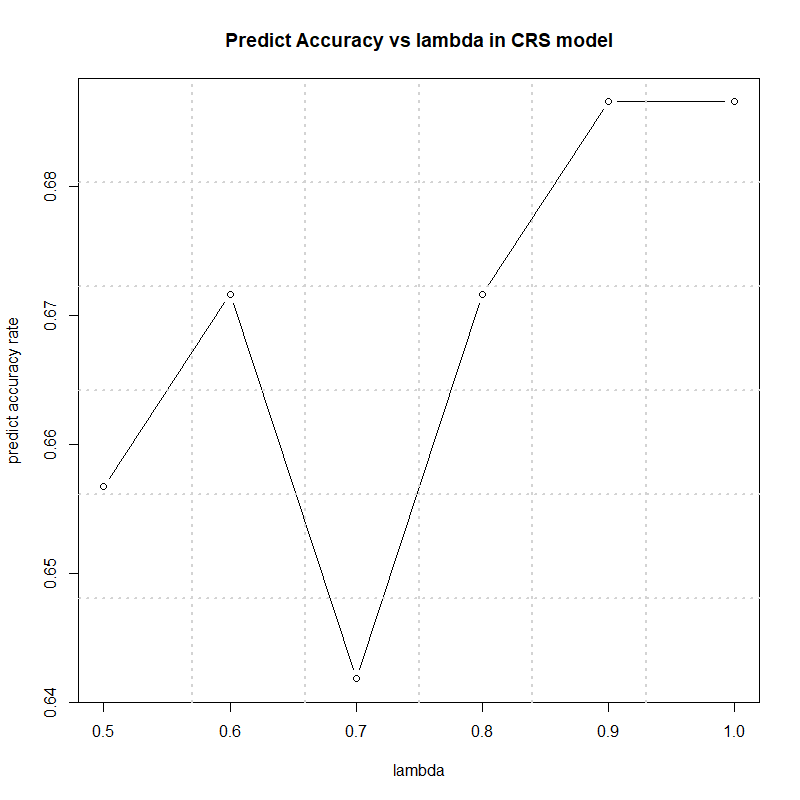
Therefore, the graph shows that the use of categorical variable TeamRegion actually harm the prediction accuracy, which imply that TeamRegion does not actually matter when we predict the game result.
Additionally, we switched the degree of tensor product spline and found that following choice of degree result in best accuracy:
SeedDiff(degree1),ScoreDiff(degree1),FGMDiff(degree1),FGM3Diff(degree1),TODiff(degree2)

which on the other hand explain the power of simple model.

# making submission

In [ ]:
MENS_DIR_2 = '../input/march-madness-analytics-2020/MDataFiles_Stage2'
WOMENS_DIR_2 = '../input/march-madness-analytics-2020/WDataFiles_Stage2'
MRegul_detailed = pd.read_csv(f'{MENS_DIR}/MRegularSeasonDetailedResults.csv')
WRegul_detailed = pd.read_csv(f'{WOMENS_DIR}/WRegularSeasonDetailedResults.csv')
M_Seed_stage1 = pd.read_csv(f'{MENS_DIR}/MNCAATourneySeeds.csv')
W_Seed_stage1 = pd.read_csv(f'{WOMENS_DIR}/WNCAATourneySeeds.csv')



In [ ]:
seed_list = [2015,2016,2017,2018,2019]
M_seed = M_Seed_stage1[M_Seed_stage1['Season'].isin(seed_list)]
W_seed = W_Seed_stage1[W_Seed_stage1['Season'].isin(seed_list)]
time_list = [2015,2016,2017,2018,2019]
MRegul_detailed = MRegul_detailed[MRegul_detailed['Season'].isin(time_list)]
WRegul_detailed = WRegul_detailed[WRegul_detailed['Season'].isin(time_list)]
win_list = ['Season','WTeamID','WScore','WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']
MRegul_detailed_win = MRegul_detailed[win_list]
WRegul_detailed_win = WRegul_detailed[win_list]

In [ ]:
MRegul_WinTeam_box = MRegul_detailed_win.groupby(['WTeamID','Season']).count()
WRegul_WinTeam_box = WRegul_detailed_win.groupby(['WTeamID','Season']).count()
drop_list = ['WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']
MRegul_WinTeam_box = MRegul_WinTeam_box.drop(drop_list,axis = 1)
WRegul_WinTeam_box = WRegul_WinTeam_box.drop(drop_list,axis = 1)
MRegul_WinTeam_box = MRegul_WinTeam_box.rename(columns = {'WScore':'count'})
WRegul_WinTeam_box = WRegul_WinTeam_box.rename(columns = {'WScore':'count'})
M_team_count = MRegul_WinTeam_box
W_team_count = WRegul_WinTeam_box

In [ ]:
MRegul_WinTeam_box = MRegul_detailed_win.groupby(['WTeamID','Season']).sum()
WRegul_WinTeam_box = WRegul_detailed_win.groupby(['WTeamID','Season']).sum()
MRegul_WinTeam_box = MRegul_WinTeam_box.reset_index()
WRegul_WinTeam_box = WRegul_WinTeam_box.reset_index()

In [ ]:
MRegul_WinTeam_box = pd.merge(MRegul_WinTeam_box,M_team_count,on = ['Season','WTeamID'])
WRegul_WinTeam_box = pd.merge(WRegul_WinTeam_box,W_team_count,on = ['Season','WTeamID'])
win_rename_columns = {'WTeamID':"TeamID","WScore":"Score",'WFGM':'FGM', 'WFGA':'FGA', 'WFGM3':'FGM3', 'WFGA3':'FGA3',
       'WFTM':'FTM', 'WFTA':'FTA', 'WOR':'OR', 'WDR':'DR', 'WAst':'Ast', 'WTO':'TO', 'WStl':'Stl', 'WBlk':'Blk', 'WPF':'PF'}
MRegul_WinTeam_box = MRegul_WinTeam_box.rename(columns = win_rename_columns)
WRegul_WinTeam_box = WRegul_WinTeam_box.rename(columns = win_rename_columns)

In [ ]:
lose_list = ['Season','LTeamID','LScore','LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR',
       'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']
MRegul_detailed_lose = MRegul_detailed[lose_list]
WRegul_detailed_lose = WRegul_detailed[lose_list]

In [ ]:
MRegul_LoseTeam_box = MRegul_detailed_lose.groupby(['LTeamID','Season']).count()
WRegul_LoseTeam_box = WRegul_detailed_lose.groupby(['LTeamID','Season']).count()
drop_list = ['LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR',
       'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']
MRegul_LoseTeam_box = MRegul_LoseTeam_box.drop(drop_list,axis = 1)
WRegul_LoseTeam_box = WRegul_LoseTeam_box.drop(drop_list,axis = 1)
MRegul_LoseTeam_box = MRegul_LoseTeam_box.rename(columns = {'LScore':'count'})
WRegul_LoseTeam_box = WRegul_LoseTeam_box.rename(columns = {'LScore':'count'})

In [ ]:
M_team_count = MRegul_LoseTeam_box
W_team_count = WRegul_LoseTeam_box
MRegul_LoseTeam_box = MRegul_detailed_lose.groupby(['LTeamID','Season']).sum()
WRegul_LoseTeam_box = WRegul_detailed_lose.groupby(['LTeamID','Season']).sum()
MRegul_LoseTeam_box = MRegul_LoseTeam_box.reset_index()
WRegul_LoseTeam_box = WRegul_LoseTeam_box.reset_index()

In [ ]:
MRegul_LoseTeam_box = pd.merge(MRegul_LoseTeam_box,M_team_count,on = ['Season','LTeamID'])
WRegul_LoseTeam_box = pd.merge(WRegul_LoseTeam_box,W_team_count,on = ['Season','LTeamID'])
lose_rename_columns = {'LTeamID':"TeamID","LScore":"Score",'LFGM':'FGM', 'LFGA':'FGA', 'LFGM3':'FGM3', 'LFGA3':'FGA3',
       'LFTM':'FTM', 'LFTA':'FTA', 'LOR':'OR', 'LDR':'DR', 'LAst':'Ast', 'LTO':'TO', 'LStl':'Stl', 'LBlk':'Blk', 'LPF':'PF'}
MRegul_LoseTeam_box = MRegul_LoseTeam_box.rename(columns = lose_rename_columns)
WRegul_LoseTeam_box = WRegul_LoseTeam_box.rename(columns = lose_rename_columns)

In [ ]:
MRegul_Team_box = MRegul_WinTeam_box.append(MRegul_LoseTeam_box)
WRegul_Team_box = WRegul_WinTeam_box.append(WRegul_LoseTeam_box)
MRegul_Team_box = MRegul_Team_box.groupby(['Season','TeamID']).sum()
WRegul_Team_box = WRegul_Team_box.groupby(['Season','TeamID']).sum()
#MRegul_Team_box = MRegul_Team_box.reset_index()
#WRegul_Team_box = WRegul_Team_box.reset_index()
element_list = ['Score','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','TO','Stl','Blk','PF','Ast']
MRegul_Team_box = MRegul_Team_box[element_list].apply(lambda x:x/MRegul_Team_box['count'])
WRegul_Team_box = WRegul_Team_box[element_list].apply(lambda x:x/WRegul_Team_box['count'])
MRegul_Team_box = MRegul_Team_box.reset_index()
WRegul_Team_box = WRegul_Team_box.reset_index()
M_seed['Seed'] = M_seed['Seed'].apply(lambda x:x[1:3])
W_seed['Seed'] = W_seed['Seed'].apply(lambda x:x[1:3])
M_seed['Seed'] = pd.to_numeric(M_seed['Seed'],errors = 'ignore')
W_seed['Seed'] = pd.to_numeric(W_seed['Seed'],errors = 'ignore')

In [ ]:
MRegul_Team_box = pd.merge(MRegul_Team_box,M_seed,on = ['Season','TeamID'],how = 'left')
WRegul_Team_box = pd.merge(WRegul_Team_box,W_seed,on = ['Season','TeamID'],how = 'left')


In [ ]:
def random_combination(team_list): #team_list:[68,1] 
    numTeam = len(team_list) 
    team_comb = np.zeros((numTeam*(numTeam-1)//2, 2)) 
    first_col = 0 
    second_col = 0 
#    print(team_list)
    for i in range(numTeam-1): 
        for ii in range(first_col,first_col+(numTeam-i-1)):
            team_comb[ii,0] = team_list[i]
        num_list = i+1 
        for iii in range(second_col,second_col+(numTeam-i-1)): 
            team_comb[iii,1] = team_list[num_list]
            num_list += 1
        first_col = first_col+(numTeam-i-1)
        second_col = second_col+(numTeam-i-1)
            
    comb = pd.DataFrame(team_comb,dtype = 'int')
    return comb

In [ ]:
#seed_list = [2015,2016,2017,2018,2019]
#M_seed = M_Seed_stage1[M_Seed_stage1['Season'].isin(seed_list)]
#W_seed = W_Seed_stage1[W_Seed_stage1['Season'].isin(seed_list)]
M_seed_2015 = M_seed[M_seed['Season'] == 2015]
W_seed_2015 = W_seed[W_seed['Season'] == 2015]
M_seed_2016 = M_seed[M_seed['Season'] == 2016]
W_seed_2016 = W_seed[W_seed['Season'] == 2016]
M_seed_2017 = M_seed[M_seed['Season'] == 2017]
W_seed_2017 = W_seed[W_seed['Season'] == 2017]
M_seed_2018 = M_seed[M_seed['Season'] == 2018]
W_seed_2018 = W_seed[W_seed['Season'] == 2018]
M_seed_2019 = M_seed[M_seed['Season'] == 2019]
W_seed_2019 = W_seed[W_seed['Season'] == 2019]

In [ ]:
M_seedsort_2015 = M_seed_2015.sort_values(by = "TeamID",ascending=True) 
W_seedsort_2015 = W_seed_2015.sort_values(by = "TeamID",ascending=True)
M_seedsort_2016 = M_seed_2016.sort_values(by = "TeamID",ascending=True)
W_seedsort_2016 = W_seed_2016.sort_values(by = "TeamID",ascending=True)
M_seedsort_2017 = M_seed_2017.sort_values(by = "TeamID",ascending=True)
W_seedsort_2017 = W_seed_2017.sort_values(by = "TeamID",ascending=True)
M_seedsort_2018 = M_seed_2018.sort_values(by = "TeamID",ascending=True)
W_seedsort_2018 = W_seed_2018.sort_values(by = "TeamID",ascending=True)
M_seedsort_2019 = M_seed_2019.sort_values(by = "TeamID",ascending=True)
W_seedsort_2019 = W_seed_2019.sort_values(by = "TeamID",ascending=True)

In [ ]:
M_list_2015 = M_seedsort_2015['TeamID'].values
W_list_2015 = W_seedsort_2015['TeamID'].values
M_list_2016 = M_seedsort_2016['TeamID'].values
W_list_2016 = W_seedsort_2016['TeamID'].values
M_list_2017 = M_seedsort_2017['TeamID'].values
W_list_2017 = W_seedsort_2017['TeamID'].values
M_list_2018 = M_seedsort_2018['TeamID'].values
W_list_2018 = W_seedsort_2018['TeamID'].values
M_list_2019 = M_seedsort_2019['TeamID'].values
W_list_2019 = W_seedsort_2019['TeamID'].values
MNCAA_gamelist_2015 = random_combination(M_list_2015)
WNCAA_gamelist_2015 = random_combination(W_list_2015)
MNCAA_gamelist_2016 = random_combination(M_list_2016)
WNCAA_gamelist_2016 = random_combination(W_list_2016)
MNCAA_gamelist_2017 = random_combination(M_list_2017)
WNCAA_gamelist_2017 = random_combination(W_list_2017)
MNCAA_gamelist_2018 = random_combination(M_list_2018)
WNCAA_gamelist_2018 = random_combination(W_list_2018)
MNCAA_gamelist_2019 = random_combination(M_list_2019)
WNCAA_gamelist_2019 = random_combination(W_list_2019)

In [ ]:
gamelist_rename_column = ['First_team','Second_team']
MNCAA_gamelist_2015.columns = gamelist_rename_column
WNCAA_gamelist_2015.columns = gamelist_rename_column
MNCAA_gamelist_2016.columns = gamelist_rename_column
WNCAA_gamelist_2016.columns = gamelist_rename_column
MNCAA_gamelist_2017.columns = gamelist_rename_column
WNCAA_gamelist_2017.columns = gamelist_rename_column
MNCAA_gamelist_2018.columns = gamelist_rename_column
WNCAA_gamelist_2018.columns = gamelist_rename_column
MNCAA_gamelist_2019.columns = gamelist_rename_column
WNCAA_gamelist_2019.columns = gamelist_rename_column

In [ ]:
MNCAA_gamelist_2015['Season'] = 2015
WNCAA_gamelist_2015['Season'] = 2015
MNCAA_gamelist_2016['Season'] = 2016
WNCAA_gamelist_2016['Season'] = 2016
MNCAA_gamelist_2017['Season'] = 2017
WNCAA_gamelist_2017['Season'] = 2017
MNCAA_gamelist_2018['Season'] = 2018
WNCAA_gamelist_2018['Season'] = 2018
MNCAA_gamelist_2019['Season'] = 2019
WNCAA_gamelist_2019['Season'] = 2019
order = ['Season','First_team','Second_team']
MNCAA_gamelist_2015 = MNCAA_gamelist_2015[order]
WNCAA_gamelist_2015 = WNCAA_gamelist_2015[order]
MNCAA_gamelist_2016 = MNCAA_gamelist_2016[order]
WNCAA_gamelist_2016 = WNCAA_gamelist_2016[order]
MNCAA_gamelist_2017 = MNCAA_gamelist_2017[order]
WNCAA_gamelist_2017 = WNCAA_gamelist_2017[order]
MNCAA_gamelist_2018 = MNCAA_gamelist_2018[order]
WNCAA_gamelist_2018 = WNCAA_gamelist_2018[order]
MNCAA_gamelist_2019 = MNCAA_gamelist_2019[order]
WNCAA_gamelist_2019 = WNCAA_gamelist_2019[order]

In [ ]:
M_gamelist = pd.concat([MNCAA_gamelist_2015,MNCAA_gamelist_2016,MNCAA_gamelist_2017,MNCAA_gamelist_2018,MNCAA_gamelist_2019])
W_gamelist = pd.concat([WNCAA_gamelist_2015,WNCAA_gamelist_2016,WNCAA_gamelist_2017,WNCAA_gamelist_2018,WNCAA_gamelist_2019])

In [ ]:
first_rename = {'TeamID':'First_team'}
second_rename = {'TeamID':'Second_team'}
M_first_team = MRegul_Team_box.rename(columns = first_rename)
W_first_team = WRegul_Team_box.rename(columns = first_rename)
M_second_team = MRegul_Team_box.rename(columns = second_rename)
W_second_team = WRegul_Team_box.rename(columns = second_rename)
MNCAA_gamebox = pd.merge(M_gamelist,M_first_team,on = ['Season','First_team'],how = 'left')
MNCAA_gamebox = pd.merge(MNCAA_gamebox,M_second_team,on = ['Season','Second_team'],how = 'left')
WNCAA_gamebox = pd.merge(W_gamelist,W_first_team,on = ['Season','First_team'],how = 'left')
WNCAA_gamebox = pd.merge(WNCAA_gamebox,W_second_team,on = ['Season','Second_team'],how = 'left')


In [ ]:
MNCAA_gamebox.to_csv('M_result.csv')
WNCAA_gamebox.to_csv('W_result.csv')

In [ ]:
MNCAA_gamebox_diff = MNCAA_gamebox
WNCAA_gamebox_diff = WNCAA_gamebox
#Men
MNCAA_gamebox_diff["Score_diff"] = MNCAA_gamebox_diff["Score_x"]-MNCAA_gamebox_diff["Score_y"]
MNCAA_gamebox_diff["FGM_diff"] = MNCAA_gamebox_diff["FGM_x"]-MNCAA_gamebox_diff["FGM_y"]
MNCAA_gamebox_diff["FGA_diff"] = MNCAA_gamebox_diff["FGA_x"]-MNCAA_gamebox_diff["FGA_y"]
MNCAA_gamebox_diff["FGM3_diff"] = MNCAA_gamebox_diff["FGM3_x"]-MNCAA_gamebox_diff["FGM3_y"]
MNCAA_gamebox_diff["FGA3_diff"] = MNCAA_gamebox_diff["FGA3_x"]-MNCAA_gamebox_diff["FGA3_y"]
MNCAA_gamebox_diff["FTM_diff"] = MNCAA_gamebox_diff["FTM_x"]-MNCAA_gamebox_diff["FTM_y"]
MNCAA_gamebox_diff["FTA_diff"] = MNCAA_gamebox_diff["FTA_x"]-MNCAA_gamebox_diff["FTA_y"]
MNCAA_gamebox_diff["OR_diff"] = MNCAA_gamebox_diff["OR_x"]-MNCAA_gamebox_diff["OR_y"]
MNCAA_gamebox_diff["DR_diff"] = MNCAA_gamebox_diff["DR_x"]-MNCAA_gamebox_diff["DR_y"]
MNCAA_gamebox_diff["TO_diff"] = MNCAA_gamebox_diff["TO_x"]-MNCAA_gamebox_diff["TO_y"]
MNCAA_gamebox_diff["Stl_diff"] = MNCAA_gamebox_diff["Stl_x"]-MNCAA_gamebox_diff["Stl_y"]
MNCAA_gamebox_diff["Ast_diff"] = MNCAA_gamebox_diff["Ast_x"]-MNCAA_gamebox_diff["Ast_y"]
MNCAA_gamebox_diff["Blk_diff"] = MNCAA_gamebox_diff["Blk_x"]-MNCAA_gamebox_diff["Blk_y"]
MNCAA_gamebox_diff["PF_diff"] = MNCAA_gamebox_diff["PF_x"]-MNCAA_gamebox_diff["PF_y"]
MNCAA_gamebox_diff["Seed_diff"] = MNCAA_gamebox_diff["Seed_x"]-MNCAA_gamebox_diff["Seed_y"]
#Women
WNCAA_gamebox_diff["Score_diff"] = WNCAA_gamebox_diff["Score_x"]-WNCAA_gamebox_diff["Score_y"]
WNCAA_gamebox_diff["FGM_diff"] = WNCAA_gamebox_diff["FGM_x"]-WNCAA_gamebox_diff["FGM_y"]
WNCAA_gamebox_diff["FGA_diff"] = WNCAA_gamebox_diff["FGA_x"]-WNCAA_gamebox_diff["FGA_y"]
WNCAA_gamebox_diff["FGM3_diff"] = WNCAA_gamebox_diff["FGM3_x"]-WNCAA_gamebox_diff["FGM3_y"]
WNCAA_gamebox_diff["FGA3_diff"] = WNCAA_gamebox_diff["FGA3_x"]-WNCAA_gamebox_diff["FGA3_y"]
WNCAA_gamebox_diff["FTM_diff"] = WNCAA_gamebox_diff["FTM_x"]-WNCAA_gamebox_diff["FTM_y"]
WNCAA_gamebox_diff["FTA_diff"] = WNCAA_gamebox_diff["FTA_x"]-WNCAA_gamebox_diff["FTA_y"]
WNCAA_gamebox_diff["OR_diff"] = WNCAA_gamebox_diff["OR_x"]-WNCAA_gamebox_diff["OR_y"]
WNCAA_gamebox_diff["DR_diff"] = WNCAA_gamebox_diff["DR_x"]-WNCAA_gamebox_diff["DR_y"]
WNCAA_gamebox_diff["TO_diff"] = WNCAA_gamebox_diff["TO_x"]-WNCAA_gamebox_diff["TO_y"]
WNCAA_gamebox_diff["Stl_diff"] = WNCAA_gamebox_diff["Stl_x"]-WNCAA_gamebox_diff["Stl_y"]
WNCAA_gamebox_diff["Ast_diff"] = WNCAA_gamebox_diff["Ast_x"]-WNCAA_gamebox_diff["Ast_y"]
WNCAA_gamebox_diff["Blk_diff"] = WNCAA_gamebox_diff["Blk_x"]-WNCAA_gamebox_diff["Blk_y"]
WNCAA_gamebox_diff["PF_diff"] = WNCAA_gamebox_diff["PF_x"]-WNCAA_gamebox_diff["PF_y"]
WNCAA_gamebox_diff["Seed_diff"] = WNCAA_gamebox_diff["Seed_x"]-WNCAA_gamebox_diff["Seed_y"]

In [ ]:
drop_list = ["Score_x","FGM_x","FGA_x","FGM3_x","FGA3_x",
            "FTM_x","FTA_x","OR_x","DR_x","TO_x","Ast_x","Stl_x","Blk_x",
           "PF_x","Score_y","FGM_y","FGA_y","FGM3_y","FGA3_y","FTM_y","FTA_y",
            "OR_y","DR_y","TO_y","Ast_y","Stl_y","Blk_y","PF_y","Seed_x","Seed_y"]
MNCAA_gamebox_diff.drop(drop_list,axis=1,inplace = True)
WNCAA_gamebox_diff.drop(drop_list,axis=1,inplace = True)

In [ ]:
MNCAA_gamebox_diff.to_csv('M_result_diff.csv')
WNCAA_gamebox_diff.to_csv('W_result_diff.csv')

In [ ]:
MNCAA_gamebox_diff

In [ ]:
MNCAA_gamebox_diff.drop(['First_team','Second_team'],axis = 1,inplace = True)

In [ ]:
order = ['Season', 'Score_diff', 'FGM_diff', 'FGA_diff', 'Ast_diff', 'FGM3_diff', 'FGA3_diff', 'FTM_diff', 'FTA_diff', 'OR_diff', 'DR_diff', 'TO_diff', 'Stl_diff', 'Blk_diff', 'PF_diff', 'Seed_diff']
MNCAA_gamebox_diff = MNCAA_gamebox_diff[order]

In [ ]:
ypred=xg_reg.predict(MNCAA_gamebox_diff)

In [ ]:
ypred

## Using PyGam

In [ ]:
!pip install pygam

In [ ]:
from pygam import LinearGAM,f,s,l
import eli5
from eli5.sklearn import PermutationImportance

## lasso selection

In [ ]:
X=x_train
y=y_train

In [ ]:
# perform LASSO CV
# Note that the regularization strength is denoted by alpha in sklearn.
from sklearn import linear_model
cv = 10
lassocv = linear_model.LassoCV(cv=cv)
lassocv.fit(X, y)
print('alpha =',lassocv.alpha_.round(4))

In [ ]:
# draw solution path
alphas = np.logspace(-8,1,21)
alphas_lassocv, coefs_lassocv, _ = lassocv.path(X, y, alphas=alphas)
log_alphas_lassocv = np.log10(alphas_lassocv)

plt.figure(figsize=(12,8)) 
plt.plot(log_alphas_lassocv,coefs_lassocv.T)
plt.vlines(x=np.log10(lassocv.alpha_), ymin=np.min(coefs_lassocv), ymax=np.max(coefs_lassocv), 
           color='b',linestyle='-.',label = 'alpha chosen')
plt.axhline(y=0, color='black',linestyle='--')
plt.xlabel(r'$\log_{10}(\alpha)$', fontsize=12)
plt.ylabel(r'$\hat{\beta}$', fontsize=12, rotation=0)
plt.title('Solution Path',fontsize=12)
plt.legend()
plt.show()

In [ ]:

# fit a multiple layer percepton (neural network)
from sklearn.neural_network import MLPClassifier
names=df_train.drop('target',axis=1).columns
names=list(names)
clf = MLPClassifier(max_iter=1000, random_state=0)
clf.fit(X, y)
# define a permutation importance object
perm = PermutationImportance(clf).fit(X, y)
# show the importance
eli5.show_weights(perm, feature_names=names)

In [ ]:
df_train[['Seeddiff','Score_y','FGM_y','FGA_y','FTM_x','FTA_x']].values
x_train =df_train[['Seeddiff','Score_y','FGM_y','FGA_y','FTM_x','FTA_x']].values
x_test =df_test[['Seeddiff','Score_y','FGM_y','FGA_y','FTM_x','FTA_x']].values
names = ['Seeddiff','Score_y','FGM_y','FGA_y','FTM_x','FTA_x']

In [ ]:
from pygam import LogisticGAM,f,s,l

gam = LogisticGAM().fit(x_train,y_train)
# f: factor term
# some parameters combinations in grid search meet the error exception.
gam.gridsearch(x_train,y_train)

In [ ]:
# plotting
fig, axs = plt.subplots(2,3,figsize=(20,8))
for i, ax in enumerate(axs.flatten()):
    XX = gam.generate_X_grid(term=i)
    plt.subplot(ax)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='grey', ls='--')
    plt.title(names[i])

In [ ]:
y_pred_train = gam.predict(x_train)
y_pred_test = gam.predict(x_test)

print('The Acc on training set:',accuracy_score(y_train,y_pred_train))
print('The Acc on testing set:',accuracy_score(y_test,y_pred_test))

### Same for women

In [ ]:
X=x_train_W
y=y_train_W

In [ ]:
# perform LASSO CV
# Note that the regularization strength is denoted by alpha in sklearn.
from sklearn import linear_model
cv = 10
lassocv = linear_model.LassoCV(cv=cv)
lassocv.fit(X, y)
print('alpha =',lassocv.alpha_.round(4))

In [ ]:
# draw solution path
alphas = np.logspace(-8,1,21)
alphas_lassocv, coefs_lassocv, _ = lassocv.path(X, y, alphas=alphas)
log_alphas_lassocv = np.log10(alphas_lassocv)

plt.figure(figsize=(12,8)) 
plt.plot(log_alphas_lassocv,coefs_lassocv.T)
plt.vlines(x=np.log10(lassocv.alpha_), ymin=np.min(coefs_lassocv), ymax=np.max(coefs_lassocv), 
           color='b',linestyle='-.',label = 'alpha chosen')
plt.axhline(y=0, color='black',linestyle='--')
plt.xlabel(r'$\log_{10}(\alpha)$', fontsize=12)
plt.ylabel(r'$\hat{\beta}$', fontsize=12, rotation=0)
plt.title('Solution Path',fontsize=12)
plt.legend()
plt.show()

In [ ]:
# fit a multiple layer percepton (neural network)
from sklearn.neural_network import MLPClassifier
names=df_train.drop('target',axis=1).columns
names=list(names)
clf = MLPClassifier(max_iter=1000, random_state=0)
clf.fit(X, y)
# define a permutation importance object
perm = PermutationImportance(clf).fit(X, y)
# show the importance
eli5.show_weights(perm, feature_names=names)

In [ ]:
x_train =df_train[['Seeddiff','Score_y','FGM_y','FGA_y','FTM_x','FTA_x']].values
x_test =df_test[['Seeddiff','Score_y','FGM_y','FGA_y','FTM_x','FTA_x']].values
names = ['Seeddiff','Score_y','FGM_y','FGA_y','FTM_x','FTA_x']
gam = LogisticGAM().fit(x_train,y_train)
# f: factor term
# some parameters combinations in grid search meet the error exception.
gam.gridsearch(x_train_W,y_train_W)

In [ ]:
# plotting
fig, axs = plt.subplots(2,3,figsize=(20,8))
for i, ax in enumerate(axs.flatten()):
    XX = gam.generate_X_grid(term=i)
    plt.subplot(ax)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='grey', ls='--')
    plt.title(names[i])
plt.tight_layout()

In [ ]:
y_pred_train = gam.predict(x_train)
y_pred_test = gam.predict(x_test)

print('The Acc on training set:',accuracy_score(y_train,y_pred_train))
print('The Acc on testing set:',accuracy_score(y_test,y_pred_test))

# Player Influence

## Begining of player stats mining

In this section, we hope to explore the impact of players objectively based on the avaliable data. We introduce four advanced statistics to describe the impact of teams and players. To be specific, the four advanced statistics are assist to turnover ratio (AT), effective field goal percentage (eFG), true shooting percentage (TS) and player efficiency rating (PER), which can be calculated acoordingly as,

AT=ASTTOAT=ASTTO

eFG%=FG+(0.5∗FGM3)FGAeFG%=FG+(0.5∗FGM3)FGA

TS%=PTS2(FGA+(0.44×FTA))TS%=PTS2(FGA+(0.44×FTA))

PER=PTS+AST+OR+DR+Block+Stl−(FGA−FGM)−(FTA−FTM)−TOmatchnumberPER=PTS+AST+OR+DR+Block+Stl−(FGA−FGM)−(FTA−FTM)−TOmatchnumber

Based on the four advanced statistics, however, it is still not easy to directly obtain the representation of players' impact. To solve this, considering the fact that the only labels we possess are game results of regular seasons and tournaments, we connect the players with teams. Specifically, we define the team's advanced statistics as the average of its player's advanced statistics and define team's impact as its winning percentage against other teams. We apply logistic regression to teams' advanced statistics with game results as labels and obtain the formula to calculate the winning rate. Then we apply this formula to calculate the players' impacts based on their advanced statistics.

In [ ]:
MENS_DIR_player = '../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data'
WOMENS_DIR_player = '../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Womens-Data'
M_players = pd.read_csv(f'{MENS_DIR_player}/MPlayers.csv')
W_players = pd.read_csv(f'{WOMENS_DIR_player}/WPlayers.csv')

##  Analysis by year

In [ ]:
def high_order_stats(event_by_player):
    event_by_player['Points'] = event_by_player['made1']+2*event_by_player['made2']+3*event_by_player['made3']
    element_list = ['assist','block','foul','made1','made2','made3','miss1','miss2','miss3',
               'reb','steal','sub','timeout','turnover','Points']
    for item in element_list:
        event_by_player[item] = event_by_player[item]/event_by_player['count']
    event_by_player['Field_goal'] = (event_by_player['made2']+
                                 event_by_player['made3'])/(event_by_player['made2']+
                                                            event_by_player['made3']+
                                                           event_by_player['miss2']+
                                                            event_by_player['miss3'])
    event_by_player['FT_goal'] = event_by_player['made1']/(event_by_player['miss1']+event_by_player['made1'])
    event_by_player['3PT'] = event_by_player['made3']/(event_by_player['miss3']+event_by_player['made3'])
    # assist vs turnover
    event_by_player['AT'] = event_by_player['assist']/event_by_player['turnover']
    event_by_player['eFG'] = (event_by_player['made2']+
                          0.5*event_by_player['made3'])/(event_by_player['made2']+
                                                         event_by_player['made3']+
                                                         event_by_player['miss2']+
                                                         event_by_player['miss3'])
    event_by_player['TS'] = event_by_player['Points']/(2*((event_by_player['made2']+
                                                         event_by_player['made3']+
                                                         event_by_player['miss2']+
                                                         event_by_player['miss3'])
                                                      +0.44*(event_by_player['made1']+
                                                         event_by_player['made1'])))
    event_by_player['PER'] = (event_by_player['Points']+event_by_player['assist']+event_by_player['reb']+event_by_player['steal']+
                         event_by_player['block']-event_by_player['miss1']-event_by_player['turnover'])/event_by_player['count']
    return event_by_player
    

mkdir('mens_stats')
mkdir('womens_stats')

In [ ]:
# year of stats
year = 2015
for year in range(2015,2020):
    M_events = pd.read_csv(f'{MENS_DIR_player}/MEvents{year}.csv')
    W_events = pd.read_csv(f'{WOMENS_DIR_player}/WEvents{year}.csv')
    M_game_made = M_events[['DayNum','EventPlayerID']]
    W_game_made = W_events[['DayNum','EventPlayerID']]
    M_game_made['count'] = 0
    W_game_made['count'] = 0
    M_game_made = M_game_made.drop_duplicates()
    W_game_made = W_game_made.drop_duplicates()
    M_game_made = M_game_made.groupby(['EventPlayerID']).count()
    M_game_made.reset_index(inplace = True)
    W_game_made = W_game_made.groupby(['EventPlayerID']).count()
    W_game_made.reset_index(inplace = True)
    M_game_made.drop(index = 0,inplace = True)
    W_game_made.drop(index = 0,inplace = True)
    M_game_made = M_game_made[['EventPlayerID','count']]
    W_game_made = W_game_made[['EventPlayerID','count']]
    M_events_useful = M_events[['EventPlayerID','EventType']]
    W_events_useful = W_events[['EventPlayerID','EventType']]
    M_events_useful['count'] = 0
    W_events_useful['count'] = 0
    M_events_useful = M_events_useful.groupby(['EventPlayerID','EventType']).count()
    W_events_useful = W_events_useful.groupby(['EventPlayerID','EventType']).count()
    M_events_reindex = M_events_useful.reset_index()
    W_events_reindex = W_events_useful.reset_index()
    M_events_pivoted=M_events_reindex.pivot('EventPlayerID', 'EventType', 'count')
    W_events_pivoted=W_events_reindex.pivot('EventPlayerID', 'EventType', 'count')
    M_event_by_player = M_events_pivoted.fillna(0)
    W_event_by_player = W_events_pivoted.fillna(0)
    M_event_by_player = M_event_by_player.drop(index = 0)
    W_event_by_player = W_event_by_player.drop(index = 0)
    M_event_by_player = pd.merge(M_event_by_player, M_game_made,on = 'EventPlayerID')
    W_event_by_player = pd.merge(W_event_by_player, W_game_made,on = 'EventPlayerID')
    M_event_by_player = high_order_stats(M_event_by_player)
    W_event_by_player = high_order_stats(W_event_by_player)
    M_players.rename(columns = {'PlayerID':'EventPlayerID'},inplace = True)
    W_players.rename(columns = {'PlayerID':'EventPlayerID'},inplace = True)

    M_player_stats = pd.merge(M_players,M_event_by_player,on = 'EventPlayerID',how = 'left')
    W_player_stats = pd.merge(W_players,W_event_by_player,on = 'EventPlayerID',how = 'left')
    M_player_stats = M_player_stats.fillna(0)
    W_player_stats = W_player_stats.fillna(0)
    
    
    M_player_stats.to_csv(f'mens_stats/M_player_stats_{year}.csv')
    W_player_stats.to_csv(f'womens_stats/W_player_stats_{year}.csv')

In [ ]:
def pre_processer(df):
    player_information=df.iloc[:,0:4]
    EventPlayerID=player_information['EventPlayerID']
    df=df.drop(['EventPlayerID','LastName','FirstName'],axis=1)
    df[df==0]=np.nan
    pd.isnull(df)
    df=df.dropna(how='all')
    df.tail()
    df.insert(0,'EventPlayerID',EventPlayerID)
    df=pd.merge(player_information, df, on='EventPlayerID')
    return df

def Team_member(df):
    number_of_teamplayer=Counter(df['TeamID'])
    #number=list(number_of_tramplayer)
    number=number_of_teamplayer.values()
    number=list(number)
    np.shape(number)
    
    return number

def TeamID_made(df):
    TeamID=list(df.drop_duplicates(['TeamID']).TeamID)
    k=len(TeamID)
    
    return TeamID

def calculator_advanced(i,df,TeamID): 
    df1=df[df['TeamID']==TeamID[i]][['AT','eFG','TS','PER']].sum()
    #df_sum=df1.append([df2,df3,df4],ignore_index = False)
    df_sum=pd.DataFrame(df1,columns=[TeamID[i]])
    return df_sum

def sum_final(df,k,TeamID):
    df[df['AT']>10000]=0
    # k=len(TeamID)
    df_sum_final=calculator_advanced(0,df,TeamID)
    for i in range (1,k):
        df_temp=calculator_advanced(i,df,TeamID)
        df_sum_final=pd.concat([df_sum_final,df_temp],axis=1)
        #df_sum_final=df_sum_final.append([df_temp],ignore_index = False)
    return df_sum_final

In [ ]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

df_2015=pd.read_csv("mens_stats/M_player_stats_2015.csv")
df_2016=pd.read_csv("mens_stats/M_player_stats_2016.csv")
df_2017=pd.read_csv("mens_stats/M_player_stats_2017.csv")
df_2018=pd.read_csv("mens_stats/M_player_stats_2018.csv")
df_2019=pd.read_csv("mens_stats/M_player_stats_2019.csv")

In [ ]:
df_2015=pre_processer(df_2015)
number_2015=Team_member(df_2015)
TeamID_2015=TeamID_made(df_2015)
k_2015=len(TeamID_2015)
df_sum_final_2015=sum_final(df_2015,k_2015,TeamID_2015)
for i in range(k_2015):
    df_sum_final_2015.iloc[:,i]=df_sum_final_2015.iloc[:,i]/number_2015[i]

df_2016=pre_processer(df_2016)
number_2016=Team_member(df_2016)
TeamID_2016=TeamID_made(df_2016)
k_2016=len(TeamID_2016)
df_sum_final_2016=sum_final(df_2016,k_2016,TeamID_2016)
for i in range(k_2016):
    df_sum_final_2016.iloc[:,i]=df_sum_final_2016.iloc[:,i]/number_2016[i]

df_2017=pre_processer(df_2017)
number_2017=Team_member(df_2017)
TeamID_2017=TeamID_made(df_2017)
k_2017=len(TeamID_2017)
df_sum_final_2017=sum_final(df_2017,k_2017,TeamID_2017)
for i in range(k_2017):
    df_sum_final_2017.iloc[:,i]=df_sum_final_2017.iloc[:,i]/number_2017[i]
    
df_2018=pre_processer(df_2018)
number_2018=Team_member(df_2018)
TeamID_2018=TeamID_made(df_2018)
k_2018=len(TeamID_2018)
df_sum_final_2018=sum_final(df_2018,k_2018,TeamID_2018)
for i in range(k_2018):
    df_sum_final_2018.iloc[:,i]=df_sum_final_2018.iloc[:,i]/number_2018[i]

df_2019=pre_processer(df_2019)
number_2019=Team_member(df_2019)
TeamID_2019=TeamID_made(df_2019)
k_2019=len(TeamID_2019)
df_sum_final_2019=sum_final(df_2019,k_2019,TeamID_2019)
for i in range(k_2019):
    df_sum_final_2019.iloc[:,i]=df_sum_final_2019.iloc[:,i]/number_2019[i]
df_sum_final_2019.tail()

In [ ]:
mkdir('player_as')

In [ ]:
df_sum_final_2015.to_csv('player_as/df_sum_final_2015.csv')
df_sum_final_2016.to_csv('player_as/df_sum_final_2016.csv')
df_sum_final_2017.to_csv('player_as/df_sum_final_2017.csv')
df_sum_final_2018.to_csv('player_as/df_sum_final_2018.csv')
df_sum_final_2019.to_csv('player_as/df_sum_final_2019.csv')
df_target=pd.read_csv("M_result_by_game_tourney_editored.csv")
df_target=df_target[['Season','WTeamID','LTeamID','target']]

In [ ]:
def preprocess_win(df,i,TeamID):
    df_new=df.T
    df_new.columns=[['AT_win','eFG_win','TS_win','PER_win']]
    df_new['Season']=i
    df_new['WTeamID']=TeamID
    
    return df_new

def preprocess_lose(df,i,TeamID):
    df_new=df.T
    df_new.columns=[['AT_lose','eFG_lose','TS_lose','PER_lose']]
    df_new['Season']=i
    df_new['LTeamID']=TeamID
    
    return df_new

In [ ]:
df_2015_new_win=preprocess_win(df_sum_final_2015,2015,TeamID_2015)
df_2016_new_win=preprocess_win(df_sum_final_2016,2016,TeamID_2016)
df_2017_new_win=preprocess_win(df_sum_final_2017,2017,TeamID_2017)
df_2018_new_win=preprocess_win(df_sum_final_2018,2018,TeamID_2018)
df_2019_new_win=preprocess_win(df_sum_final_2019,2019,TeamID_2019)
df_2015_new_lose=preprocess_lose(df_sum_final_2015,2015,TeamID_2015)
df_2016_new_lose=preprocess_lose(df_sum_final_2016,2016,TeamID_2016)
df_2017_new_lose=preprocess_lose(df_sum_final_2017,2017,TeamID_2017)
df_2018_new_lose=preprocess_lose(df_sum_final_2018,2018,TeamID_2018)
df_2019_new_lose=preprocess_lose(df_sum_final_2019,2019,TeamID_2019)

In [ ]:
df1=df_2015_new_win.append(df_2016_new_win)
df2=df1.append(df_2017_new_win)
df3=df2.append(df_2018_new_win)
df4=df3.append(df_2019_new_win)
df_final_win=df4

In [ ]:
df1=df_2015_new_lose.append(df_2016_new_lose)
df2=df1.append(df_2017_new_lose)
df3=df2.append(df_2018_new_lose)
df4=df3.append(df_2019_new_lose)
df_final_lose=df4

In [ ]:
df_final_win.columns=df_final_win.columns.get_level_values(0)

In [ ]:
#第一句话不被运行是第一次的时候才用：
df_target_new=pd.merge(df_target,df_final_win,on = ['Season','WTeamID'],how='left')
df_final_lose.columns=df_final_lose.columns.get_level_values(0)
df_target_new=pd.merge(df_target_new,df_final_lose,on = ['Season','LTeamID'],how='left')

In [ ]:
df_target_new.to_csv('with_advanced_stat.csv')
df_2015=pd.read_csv("womens_stats/W_player_stats_2015.csv")
df_2016=pd.read_csv("womens_stats/W_player_stats_2016.csv")
df_2017=pd.read_csv("womens_stats/W_player_stats_2017.csv")
df_2018=pd.read_csv("womens_stats/W_player_stats_2018.csv")
df_2019=pd.read_csv("womens_stats/W_player_stats_2019.csv")

In [ ]:
df_2015=pre_processer(df_2015)
number_2015=Team_member(df_2015)
TeamID_2015=TeamID_made(df_2015)
k_2015=len(TeamID_2015)
df_sum_final_2015=sum_final(df_2015,k_2015,TeamID_2015)
for i in range(k_2015):
    df_sum_final_2015.iloc[:,i]=df_sum_final_2015.iloc[:,i]/number_2015[i]

df_2016=pre_processer(df_2016)
number_2016=Team_member(df_2016)
TeamID_2016=TeamID_made(df_2016)
k_2016=len(TeamID_2016)
df_sum_final_2016=sum_final(df_2016,k_2016,TeamID_2016)
for i in range(k_2016):
    df_sum_final_2016.iloc[:,i]=df_sum_final_2016.iloc[:,i]/number_2016[i]

df_2017=pre_processer(df_2017)
number_2017=Team_member(df_2017)
TeamID_2017=TeamID_made(df_2017)
k_2017=len(TeamID_2017)
df_sum_final_2017=sum_final(df_2017,k_2017,TeamID_2017)
for i in range(k_2017):
    df_sum_final_2017.iloc[:,i]=df_sum_final_2017.iloc[:,i]/number_2017[i]
    
df_2018=pre_processer(df_2018)
number_2018=Team_member(df_2018)
TeamID_2018=TeamID_made(df_2018)
k_2018=len(TeamID_2018)
df_sum_final_2018=sum_final(df_2018,k_2018,TeamID_2018)
for i in range(k_2018):
    df_sum_final_2018.iloc[:,i]=df_sum_final_2018.iloc[:,i]/number_2018[i]

df_2019=pre_processer(df_2019)
number_2019=Team_member(df_2019)
TeamID_2019=TeamID_made(df_2019)
k_2019=len(TeamID_2019)
df_sum_final_2019=sum_final(df_2019,k_2019,TeamID_2019)
for i in range(k_2019):
    df_sum_final_2019.iloc[:,i]=df_sum_final_2019.iloc[:,i]/number_2019[i]
df_sum_final_2019.tail()

In [ ]:
df_sum_final_2015.to_csv('player_as/W_df_sum_final_2015.csv')
df_sum_final_2016.to_csv('player_as/W_df_sum_final_2016.csv')
df_sum_final_2017.to_csv('player_as/W_df_sum_final_2017.csv')
df_sum_final_2018.to_csv('player_as/W_df_sum_final_2018.csv')
df_sum_final_2019.to_csv('player_as/W_df_sum_final_2019.csv')

In [ ]:
df_target=pd.read_csv("W_result_by_game_tourney_editored.csv")
df_target=df_target[['Season','WTeamID','LTeamID','target']]

In [ ]:
df_2015_new_win=preprocess_win(df_sum_final_2015,2015,TeamID_2015)
df_2016_new_win=preprocess_win(df_sum_final_2016,2016,TeamID_2016)
df_2017_new_win=preprocess_win(df_sum_final_2017,2017,TeamID_2017)
df_2018_new_win=preprocess_win(df_sum_final_2018,2018,TeamID_2018)
df_2019_new_win=preprocess_win(df_sum_final_2019,2019,TeamID_2019)
df_2015_new_lose=preprocess_lose(df_sum_final_2015,2015,TeamID_2015)
df_2016_new_lose=preprocess_lose(df_sum_final_2016,2016,TeamID_2016)
df_2017_new_lose=preprocess_lose(df_sum_final_2017,2017,TeamID_2017)
df_2018_new_lose=preprocess_lose(df_sum_final_2018,2018,TeamID_2018)
df_2019_new_lose=preprocess_lose(df_sum_final_2019,2019,TeamID_2019)

In [ ]:
df1=df_2015_new_win.append(df_2016_new_win)
df2=df1.append(df_2017_new_win)
df3=df2.append(df_2018_new_win)
df4=df3.append(df_2019_new_win)
df_final_win=df4

df1=df_2015_new_lose.append(df_2016_new_lose)
df2=df1.append(df_2017_new_lose)
df3=df2.append(df_2018_new_lose)
df4=df3.append(df_2019_new_lose)
df_final_lose=df4

In [ ]:
df_final_win.columns=df_final_win.columns.get_level_values(0)
#第一句话不被运行是第一次的时候才用：
df_target_new=pd.merge(df_target,df_final_win,on = ['Season','WTeamID'],how='left')
df_target_new.tail()

In [ ]:
df_final_lose.columns=df_final_lose.columns.get_level_values(0)
df_target_new_W=pd.merge(df_target_new,df_final_lose,on = ['Season','LTeamID'],how='left')
df_target_new_W.to_csv('W_with_advanced_stat.csv')

## Regression

In [ ]:
df=df_target_new
#order=['Season','WTeamID','LTeamID','AT_win','eFG_win','TS_win','PER_win','AT_lose','eFG_lose','TS_lose','PER_lose','target']
target=df['target']
df=df.drop('target',axis=1)
df['target']=target
df.tail()

#### We use pairplot to show the bivariate data relation.
#### Where we find "target=1" group shows a tighter convergence than "target=0" group. There is a different distribution of these four advanced statistics(AT,eFG,TS,PER) according to these two "targets", that is to say to some degree, "target" can be explained by these four stats. Hence, we then use Logistic Regression.

In [ ]:
df_plot=df[['target','AT_win','eFG_win','TS_win','PER_win']]
sns.pairplot(df_plot, hue="target", size=3, diag_kind="kde")

In [ ]:
# Split the data 
df_train=df[df['Season']<2019]
df_test=df[df['Season']>2018]

df_train=df_train.drop(['Season','WTeamID','LTeamID'],axis=1)
df_test=df_test.drop(['Season','WTeamID','LTeamID'],axis=1)

m,n=np.shape(df_train)

x_train = df_train.iloc[:,0:n-1].values
y_train = df_train.target.values

x_test = df_test.iloc[:,0:n-1].values
y_test = df_test.target.values

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
logreg = LogisticRegressionCV(cv=5,random_state=0, solver='newton-cg')
logreg.fit(x_train, y_train)

y_pred_train = logreg.predict(x_train)
y_pred_test = logreg.predict(x_test)

print("Coefficients :", np.round(logreg.intercept_,4), np.round(logreg.coef_,4))

In [ ]:
y_pred_train = logreg.predict(x_train)
y_pred_test = logreg.predict(x_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Accuracy on the training set =', np.round(accuracy_train,4))
print('Accuracy on the test set =', np.round(accuracy_test,4))

## same for women

In [ ]:
df=df_target_new_W
#order=['Season','WTeamID','LTeamID','AT_win','eFG_win','TS_win','PER_win','AT_lose','eFG_lose','TS_lose','PER_lose','target']
target=df['target']
df=df.drop('target',axis=1)
df['target']=target
df.tail()

In [ ]:
df_plot=df[['target','AT_win','eFG_win','TS_win','PER_win']]
sns.pairplot(df_plot, hue="target", size=3, diag_kind="kde")

In [ ]:
# Split the data 
df_train=df[df['Season']<2019]
df_test=df[df['Season']>2018]

df_train=df_train.drop(['Season','WTeamID','LTeamID'],axis=1)
df_test=df_test.drop(['Season','WTeamID','LTeamID'],axis=1)

m,n=np.shape(df_train)

x_train = df_train.iloc[:,0:n-1].values
y_train = df_train.target.values

x_test = df_test.iloc[:,0:n-1].values
y_test = df_test.target.values

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
logreg = LogisticRegressionCV(cv=5,random_state=0, solver='newton-cg')
logreg.fit(x_train, y_train)

y_pred_train = logreg.predict(x_train)
y_pred_test = logreg.predict(x_test)

print("Coefficients :", np.round(logreg.intercept_,4), np.round(logreg.coef_,4))

In [ ]:
y_pred_train = logreg.predict(x_train)
y_pred_test = logreg.predict(x_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Accuracy on the training set =', np.round(accuracy_train,4))
print('Accuracy on the test set =', np.round(accuracy_test,4))

In [ ]:
df_2015=df_2015[['AT','eFG','TS','PER','TeamID']]
df_2016=df_2016[['AT','eFG','TS','PER','TeamID']]
df_2017=df_2017[['AT','eFG','TS','PER','TeamID']]
df_2018=df_2018[['AT','eFG','TS','PER','TeamID']]
df_2019=df_2019[['AT','eFG','TS','PER','TeamID']]

In [ ]:
coef=np.round(logreg.coef_,4)
coef[0][0:4]

In [ ]:
def project(df):
    df_player_influence=0
    for i in range(4):  
        df_player_influence=coef[0][i]*df.iloc[:,i]+df_player_influence
    df['player_influence']=df_player_influence
    return df

In [ ]:
df_2015_new=project(df_2015)
df_2016_new=project(df_2016)
df_2017_new=project(df_2017)
df_2018_new=project(df_2018)
df_2019_new=project(df_2019)

df_2015_new.dropna(axis=0,how='any',inplace=True)
df_2016_new.dropna(axis=0,how='any',inplace=True)
df_2017_new.dropna(axis=0,how='any',inplace=True)
df_2018_new.dropna(axis=0,how='any',inplace=True)
df_2019_new.dropna(axis=0,how='any',inplace=True)

# Impact

In [ ]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

df_2015=pd.read_csv("mens_stats/M_player_stats_2015.csv")
df_2016=pd.read_csv("mens_stats/M_player_stats_2016.csv")
df_2017=pd.read_csv("mens_stats/M_player_stats_2017.csv")
df_2018=pd.read_csv("mens_stats/M_player_stats_2018.csv")
df_2019=pd.read_csv("mens_stats/M_player_stats_2019.csv")

In [ ]:
df_2015=pre_processer(df_2015)
number_2015=Team_member(df_2015)
TeamID_2015=TeamID_made(df_2015)
k_2015=len(TeamID_2015)
df_sum_final_2015=sum_final(df_2015,k_2015,TeamID_2015)
for i in range(k_2015):
    df_sum_final_2015.iloc[:,i]=df_sum_final_2015.iloc[:,i]/number_2015[i]

df_2016=pre_processer(df_2016)
number_2016=Team_member(df_2016)
TeamID_2016=TeamID_made(df_2016)
k_2016=len(TeamID_2016)
df_sum_final_2016=sum_final(df_2016,k_2016,TeamID_2016)
for i in range(k_2016):
    df_sum_final_2016.iloc[:,i]=df_sum_final_2016.iloc[:,i]/number_2016[i]

df_2017=pre_processer(df_2017)
number_2017=Team_member(df_2017)
TeamID_2017=TeamID_made(df_2017)
k_2017=len(TeamID_2017)
df_sum_final_2017=sum_final(df_2017,k_2017,TeamID_2017)
for i in range(k_2017):
    df_sum_final_2017.iloc[:,i]=df_sum_final_2017.iloc[:,i]/number_2017[i]
    
df_2018=pre_processer(df_2018)
number_2018=Team_member(df_2018)
TeamID_2018=TeamID_made(df_2018)
k_2018=len(TeamID_2018)
df_sum_final_2018=sum_final(df_2018,k_2018,TeamID_2018)
for i in range(k_2018):
    df_sum_final_2018.iloc[:,i]=df_sum_final_2018.iloc[:,i]/number_2018[i]

df_2019=pre_processer(df_2019)
number_2019=Team_member(df_2019)
TeamID_2019=TeamID_made(df_2019)
k_2019=len(TeamID_2019)
df_sum_final_2019=sum_final(df_2019,k_2019,TeamID_2019)
for i in range(k_2019):
    df_sum_final_2019.iloc[:,i]=df_sum_final_2019.iloc[:,i]/number_2019[i]

In [ ]:
df_2015=df_2015[['AT','eFG','TS','PER','TeamID']]
df_2016=df_2016[['AT','eFG','TS','PER','TeamID']]
df_2017=df_2017[['AT','eFG','TS','PER','TeamID']]
df_2018=df_2018[['AT','eFG','TS','PER','TeamID']]
df_2019=df_2019[['AT','eFG','TS','PER','TeamID']]

df_2015_new=project(df_2015)
df_2016_new=project(df_2016)
df_2017_new=project(df_2017)
df_2018_new=project(df_2018)
df_2019_new=project(df_2019)

df_2015_new.dropna(axis=0,how='any',inplace=True)
df_2016_new.dropna(axis=0,how='any',inplace=True)
df_2017_new.dropna(axis=0,how='any',inplace=True)
df_2018_new.dropna(axis=0,how='any',inplace=True)
df_2019_new.dropna(axis=0,how='any',inplace=True)

In [ ]:
def impact_object(df):
    df_influence = df[df['player_influence']>0]
    df_influence=df_influence['player_influence']
    
    return df_influence

In [ ]:
def impact(df):
    tstat2015=df
    tstat2015["impact"] = tstat2015["Points"]+tstat2015["made1"]+tstat2015["made2"]-tstat2015["miss1"]- \
                tstat2015["miss2"]+tstat2015["reb"]+tstat2015["assist"]+tstat2015["steal"] \
                +0.5*tstat2015["block"]-tstat2015["foul"]-tstat2015["turnover"]
    a = tstat2015[tstat2015["impact"]>0]
    a=a['impact']
    return a

In [ ]:
tstat2015 = pd.read_csv("mens_stats/M_player_stats_2015.csv")
tstat2016 = pd.read_csv("mens_stats/M_player_stats_2016.csv")
tstat2017 = pd.read_csv("mens_stats/M_player_stats_2017.csv")
tstat2018 = pd.read_csv("mens_stats/M_player_stats_2018.csv")
tstat2019 = pd.read_csv("mens_stats/M_player_stats_2019.csv")

To demonstrate the effect of our proposed method (denoted as ours)to calculate players' impact, we compare our method with official impact formula (denoted as offi). 
The following graphs shows the distribution of players' impact calculated by ours and offi.

In [ ]:
fig, ax = plt.subplots(5,2, figsize=(12, 16), facecolor='#f7f7f7')
#sns.set_style("ticks")
sns.set_style("darkgrid")
sns.kdeplot(data=impact(tstat2015),ax=ax[0][0],label="Player_offi_2015" ,shade=True)
sns.kdeplot(data=impact_object(df_2015_new),ax=ax[0][1],label="Player_ours_2015" ,shade=True)

sns.kdeplot(data=impact(tstat2016),ax=ax[1][0],label="Player_offi_2016" ,shade=True)
sns.kdeplot(data=impact_object(df_2016_new),ax=ax[1][1],label="Player_ours_2016" ,shade=True)

sns.kdeplot(data=impact(tstat2017),ax=ax[2][0],label="Player_offi_2017" ,shade=True)
sns.kdeplot(data=impact_object(df_2017_new),ax=ax[2][1],label="Player_ours_2017" ,shade=True)

sns.kdeplot(data=impact(tstat2018),ax=ax[3][0],label="Player_offi_2018" ,shade=True)
sns.kdeplot(data=impact_object(df_2018_new),ax=ax[3][1],label="Player_ours_2018" ,shade=True)

sns.kdeplot(data=impact(tstat2019),ax=ax[4][0],label="Player_offi_2019" ,shade=True)
sns.kdeplot(data=impact_object(df_2019_new),ax=ax[4][1],label="Player_ours_2019" ,shade=True)
#sns.kdeplot(data=impact_object(df_2015_new),label="Player_influence_2015" ,shade=True)

### Win rate:

From the graphs, we discover that the shapes of the two formulas' distribution are roughly similar. To better compare the power of ours and offi, we design an experiment as follows. We calculate the impact of each player in the above two ways, sort the top 50% and define them as "good players". A team tends to be more competitive when it has more "good players". We count the number of "good players" of each team and sort the top 20. These teams are chosen as competitive teams respectively by ours and offi. We calculate the actual winning rate of these teams of the picking season and sum. A higher winning rate sum means the method is better at describing the impact. The results are as follows.  

### 2015

#### Official Definition Win Rate:

In [ ]:
a = tstat2015[tstat2015["impact"]>0]
b = a.sort_values(by = "impact",ascending=False)

mrc = pd.read_csv(f'../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
mrc = mrc[mrc["Season"]==2015]
w = mrc['WTeamID'].value_counts()
l = mrc["LTeamID"].value_counts()
winrate = w/(w+l)
winrate[1246] = 1
c = b['TeamID'].value_counts()
np.sum(winrate[c[0:20].index])

#### Our Method Win Rate:

In [ ]:
quantile_2015_50=df_2015_new['player_influence'].describe()['50%']
df_2015_thresh=np.where(df_2015_new['player_influence']<quantile_2015_50,np.nan,1)
#df_2015_new['player_influence'].dropna(axis=0,how='any',inplace=True)
df_2015_new['player_influence']=df_2015_thresh
df_2015_compare=df_2015_new.dropna(axis=0,how='any')
df_2015_compare.tail()
index_2015=df_2015_compare['TeamID'].value_counts()
np.sum(winrate[index_2015[0:20].index])
#index_2015[1:20].index

#### 2017

#### Official Definition Win Rate:

In [ ]:
a = tstat2017[tstat2017["impact"]>0]
b = a.sort_values(by = "impact",ascending=False)
mrc = pd.read_csv(f'../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
mrc = mrc[mrc["Season"]==2017]
w = mrc['WTeamID'].value_counts()
l = mrc["LTeamID"].value_counts()
winrate = w/(w+l)
#winrate[1246] = 1
c = b['TeamID'].value_counts()
np.sum(winrate[c[0:20].index])


#### Our Method Win Rate:

In [ ]:
quantile_2017_50=df_2017_new['player_influence'].describe()['50%']
df_2017_thresh=np.where(df_2017_new['player_influence']<quantile_2017_50,np.nan,1)
#df_2015_new['player_influence'].dropna(axis=0,how='any',inplace=True)
df_2017_new['player_influence']=df_2017_thresh
df_2017_compare=df_2017_new.dropna(axis=0,how='any')
df_2017_compare.tail()
index_2017=df_2017_compare['TeamID'].value_counts()
np.sum(winrate[index_2017[0:20].index])

#### 2019

#### Official Definition Win Rate:

In [ ]:
a = tstat2019[tstat2019["impact"]>0]
b = a.sort_values(by = "impact",ascending=False)
mrc = pd.read_csv(f'../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
mrc = mrc[mrc["Season"]==2019]
w = mrc['WTeamID'].value_counts()
l = mrc["LTeamID"].value_counts()
winrate = w/(w+l)
#winrate[1246] = 1
c = b['TeamID'].value_counts()
np.sum(winrate[c[0:20].index])

#### Our Method Win Rate:

In [ ]:
quantile_2019_50=df_2019_new['player_influence'].describe()['50%']
df_2019_thresh=np.where(df_2019_new['player_influence']<quantile_2019_50,np.nan,1)
#df_2015_new['player_influence'].dropna(axis=0,how='any',inplace=True)
df_2019_new['player_influence']=df_2019_thresh
df_2019_compare=df_2019_new.dropna(axis=0,how='any')
df_2019_compare.tail()
index_2019=df_2019_compare['TeamID'].value_counts()
np.sum(winrate[index_2019[0:20].index])

# Team Influence:

Then we use the average influence of players in the same team to represent this team's influence. Based on the output of the previous five years(2015-2019), we then use the ARIMA model to predict the result in 2020. It may be too tricky to predict the team influence only based on five previous data, however, this problem can be handled if we have enough data.

In [ ]:
def sum_influence(df,k,TeamID,q,number):
    # k=len(TeamID)
    df_sum_final=[]
    df_sum_final.append(df[df['TeamID']==TeamID[0]]['player_influence'].sum())
    lists=['influence_2015','influence_2016','influence_2017','influence_2018','influence_2019']
    for i in range (1,k):
        df_temp=df[df['TeamID']==TeamID[i]]['player_influence'].sum()
        df_sum_final.append(df_temp)
        #df_sum_final=df_sum_final.append([df_temp],ignore_index = False)
    df_sum_final=pd.DataFrame(df_sum_final,columns=[lists[q]])
    for i in range(k):
        df_sum_final.loc[i]=df_sum_final.loc[i]/number[i]
    return df_sum_final

In [ ]:
team_2015_influence=sum_influence(df_2015_new,k_2015,TeamID_2015,0,number_2015)
team_2015_influence['Season_2015']=2015
team_2015_influence['TeamID']=TeamID_2015

team_2016_influence=sum_influence(df_2016_new,k_2016,TeamID_2016,1,number_2016)
team_2016_influence['Season_2016']=2016
team_2016_influence['TeamID']=TeamID_2016

team_2017_influence=sum_influence(df_2017_new,k_2017,TeamID_2017,2,number_2017)
team_2017_influence['Season_2017']=2017
team_2017_influence['TeamID']=TeamID_2017

team_2018_influence=sum_influence(df_2018_new,k_2018,TeamID_2018,3,number_2018)
team_2018_influence['Season_2018']=2018
team_2018_influence['TeamID']=TeamID_2018

team_2019_influence=sum_influence(df_2019_new,k_2019,TeamID_2019,4,number_2019)
team_2019_influence['Season_2019']=2019
team_2019_influence['TeamID']=TeamID_2019

In [ ]:
df_1=pd.merge(team_2015_influence,team_2016_influence,on=['TeamID'])
df_2=pd.merge(df_1,team_2017_influence,on=['TeamID'])
df_3=pd.merge(df_2,team_2018_influence,on=['TeamID'])
df_final_influence=pd.merge(df_3,team_2019_influence,on=['TeamID'])
df_final_influence=df_final_influence.drop(['Season_2015','Season_2016','Season_2017','Season_2018','Season_2019'],axis=1)
TeamID=df_final_influence['TeamID']
df_final_influence.drop(['TeamID'],axis=1,inplace=True)
df_final_influence.insert(0,'TeamID',TeamID)
df_final_influence.tail()

In [ ]:
df_final_influence.to_csv('team_influence_time_series.csv')

In [ ]:
!pip install pmdarima

In [ ]:
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

df_input=df_final_influence.iloc[:,1:6]
df_input=df_input.T
df_input.tail()


def auto_arima(df,i):
    model = pm.auto_arima(df.iloc[:,i], trace=False, error_action='ignore', suppress_warnings=True)
    model.fit(df.iloc[:,i])
    forecast = model.predict(n_periods=1)
    
    return forecast

In [ ]:
m,n=np.shape(df_input)
result=[]
for i in range(n):
    temp=auto_arima(df_input,i)
    result.append(temp)

In [ ]:
result=pd.DataFrame(result,columns=['prediction_2020'])
result=result.T

In [ ]:
df_output=df_input.append(result)

In [ ]:
df_output.to_csv('team_influence_prediction.csv')

In [ ]:
!pip install chart_studio
!pip install bubbly

In [ ]:
df_output_new=df_output.T
df_1=df_output_new[['influence_2015']]
df_1.rename(columns={'influence_2015': 'influence'}, inplace=True)
df_1['teamid']=TeamID
df_1['season']='Real'

df_2=df_output_new[['influence_2016']]
df_2.rename(columns={'influence_2016': 'influence'}, inplace=True)
df_2['teamid']=TeamID
df_2['season']='Real'

df_3=df_output_new[['influence_2017']]
df_3.rename(columns={'influence_2017': 'influence'}, inplace=True)
df_3['teamid']=TeamID
df_3['season']='Real'

df_4=df_output_new[['influence_2018']]
df_4.rename(columns={'influence_2018': 'influence'}, inplace=True)
df_4['teamid']=TeamID
df_4['season']='Real'

df_5=df_output_new[['influence_2019']]
df_5.rename(columns={'influence_2019': 'influence'}, inplace=True)
df_5['teamid']=TeamID
df_5['season']='Real'

df_6=df_output_new[['prediction_2020']]
df_6.rename(columns={'prediction_2020': 'influence'}, inplace=True)
df_6['teamid']=TeamID
df_6['season']='Prediction'

df_bubble=pd.concat([df_1,df_2,df_3,df_4,df_5,df_6],axis=0)
df_bubble

#df_bubble.iloc[:,0]=df_bubble.iloc[:,0]-min(df_bubble.iloc[:,0])
df_bubble.reset_index(drop=True, inplace=True)
df_bubble.sort_values(by='influence',ascending=False,inplace=True)
df_bubble_plot=df_bubble.head(50)
df_bubble_plot.tail()

In [ ]:
from bubbly.bubbly import bubbleplot 
from plotly.offline import iplot
import chart_studio.plotly as py

figure = bubbleplot(dataset=df_bubble_plot, x_column='teamid', y_column='influence', 
                    bubble_column='season', size_column='influence', color_column='season', 
                    x_logscale=True, scale_bubble=1, height=350)

iplot(figure)

In [ ]:
import seaborn as sns
df_influence = df_bubble['influence']
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
sns.kdeplot(data=df_influence,label="Team_Competitiveness" ,shade=True)

# Limits and next steps

### Conclusion,Limits and next Steps

In this notebook, we started with prediction of tournament results in season 2019-2020 based on some machine learning models(Logistic Regression, Xgboost and  Pygam) to find the relation between competition results with the core statistics. Doing so, we are now able to predict the competition results based on these core statistics which we have known during the regular season. Then we use an original method as objective as possible to measure players' infuence--using four advanced players' stats as inputs and competition results as targets to build logistic regression model. Our experiments verifies the superiority of our method.

There are two potential limits
* Naturally, taking men's data as an example, our prediction accuracy can not be higher above 0.75 even when we add independent variables as much as we can or delete some uncorrelated variables intuitively. Also using "Lasso-$L_1$ " as our penalty, we observe that a large amount of independent variables is useless and "MLP Classifier" also verifies this observation. Through "MLP Classifier" we find that the independent variable "Sedddiff" is most significant than any other variable. "Seeddiff" seems to be dominant in prediction, hence it is hard for these model to find "cinderellas". Since in these models, seed_01 always wins seed_16.


* Another limitation that we should address is that our objective method related to player influence may exist endogenous problem, since we only select four advanced stats as our logistic regression model inputs. However, it may be not enough that only include this four independent variables. For example, the omitted variable --'Score' is correlated with PER and thus results in endogenous problem.

Looking ahead, we could try to remove the most significant independent variable--"Seeddiff" and then build the model again. It may sacrifice some accuracy but can find "cinderellas". Another way to find "cinderellas" is that define a metric subjectively to measure which team is a potential "cinderellas". For example, in season 2018-2019, if seed_16(team A) has won seed_01(team B) and then in season 2019-2020, team A is more likely to be "cinderellas". After selecting these knids of teams as a sub-dataset, we build the model alone with this sub-dataset to find "cinderellas".To address potential endogenous problem, we can use 2SLS(two stages least squares) or add some potential omitted variables intuitively and compare the results.

On the other hand, one could argue that embedded in player influence there is an element of unpredictability.
* There is a player and season 2019-2020 is his/her first season.
* Player accident injury
* Players' breakthrough in physical fitness or basketball skills

### References
* [Comparition on differences between Men's and Women's tournaments](https://www.kaggle.com/lucabasa/are-men-s-and-women-s-tournaments-different)
* [Impact index defines competiveness](http://www.kaggle.com/lucabasa/quantify-the-madness-a-study-of-competitiveness)